In [18]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy as sp

In [56]:
log_dirs = Path(r"./final_results_internal/"), Path(r"./final_results/")

In [52]:
def get_all_results(log_dir, metric):
    runs = []
    for run_instance in log_dir.iterdir():
        if run_instance.is_dir():
            iteration_result = Path(run_instance / "data_frames" / f"{metric}.csv")
            if iteration_result.exists():
                result = pd.read_csv(open(iteration_result), index_col=0)
                runs.append(result)
    return pd.concat(runs)

In [10]:
internal_samples

,30d_mortality,90d_mortality
DummyClassifier,0.512195,0.524390
DecisionTreeClassifier,0.058479,0.073848
RandomForestClassifier,0.070261,0.307226
GradientBoostingClassifier,0.058194,0.230749
LogisticRegression,0.030643,0.300884
...,...,...
GradientBoostingClassifier,0.020470,0.111809
LogisticRegression,0.017683,0.150739
SVC,0.017687,0.198698
LinearSVC,0.018913,0.208106


In [11]:
external_samples

,Death_within_primary_stay,30d_mortality,90d_mortality
DummyClassifier,0.550676,0.520270,0.543919
DecisionTreeClassifier,0.160068,0.145568,0.216649
RandomForestClassifier,0.263725,0.033970,0.292587
GradientBoostingClassifier,0.253270,0.101225,0.260445
LogisticRegression,0.348185,0.291950,0.442342
...,...,...,...
GradientBoostingClassifier,0.200736,0.092934,0.126699
LogisticRegression,0.240921,0.290794,0.461976
SVC,0.305837,0.245597,0.386102
LinearSVC,0.257475,0.135002,0.463012


In [61]:
for metric in ['roc_auc', 'prc_auc', 'mcc']:
    side = 'greater' if metric == 'roc_auc' else 'less'
    print(f"{metric} (testing if training cohort is {side} than validation cohort)")
    internal_samples = get_all_results(log_dirs[0], metric)
    external_samples = get_all_results(log_dirs[1], metric)
    for model in external_samples.index.unique():
        if model == "DummyClassifier":
            continue
        print(f"\t{model}")
        for endpoint in ['90d_mortality', '30d_mortality']:
            single_model_internal_samples = list(internal_samples.loc[model, endpoint])
            single_model_external_samples = list(external_samples.loc[model, endpoint])
            mwu_results = sp.stats.mannwhitneyu(single_model_internal_samples, single_model_external_samples, alternative=side)
            if mwu_results.pvalue >= 0.05:
                second_mwu_results = sp.stats.mannwhitneyu(single_model_external_samples, single_model_internal_samples, alternative=side)
                if second_mwu_results.pvalue >= 0.05:
                    print(f"\t\t{endpoint} - p-value = {mwu_results.pvalue}\t NOT SIGNIFICANT IN EITHER DIRECTION")
                else:
                    print(f"\t\t{endpoint} - p-value = {mwu_results.pvalue}\t SIGNIFICANT IN OPPOSITE DIRECTION")
            else:
                print(f"\t\t{endpoint} - p-value = {mwu_results.pvalue}")

roc_auc (testing if training cohort is greater than validation cohort)
	DecisionTreeClassifier
		90d_mortality - p-value = 0.4771044046860516	 NOT SIGNIFICANT IN EITHER DIRECTION
		30d_mortality - p-value = 0.9930604516260937	 SIGNIFICANT IN OPPOSITE DIRECTION
	RandomForestClassifier
		90d_mortality - p-value = 4.371837209631497e-08
		30d_mortality - p-value = 0.5817877994586954	 NOT SIGNIFICANT IN EITHER DIRECTION
	GradientBoostingClassifier
		90d_mortality - p-value = 0.33358169133526294	 NOT SIGNIFICANT IN EITHER DIRECTION
		30d_mortality - p-value = 0.022101726216964764
	LogisticRegression
		90d_mortality - p-value = 0.00033952078827225075
		30d_mortality - p-value = 0.8312526797398458	 NOT SIGNIFICANT IN EITHER DIRECTION
	SVC
		90d_mortality - p-value = 7.210876416235874e-05
		30d_mortality - p-value = 0.6352839029123372	 NOT SIGNIFICANT IN EITHER DIRECTION
	LinearSVC
		90d_mortality - p-value = 1.0542931765757739e-07
		30d_mortality - p-value = 0.9842013562172847	 SIGNIFICANT IN 

In [42]:
single_model_internal_samples = list(internal_samples.loc["RandomForestClassifier", "30d_mortality"])
single_model_external_samples = list(external_samples.loc["RandomForestClassifier", "30d_mortality"])

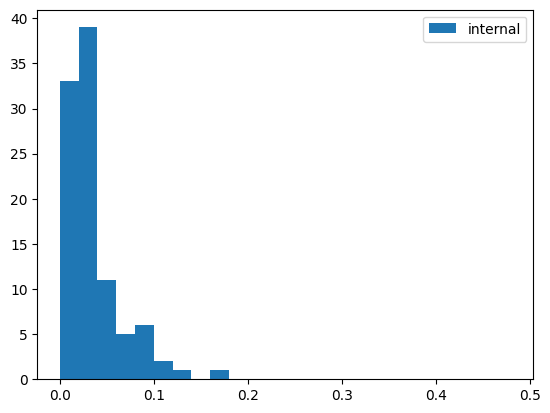

In [43]:
plt.hist(single_model_internal_samples, bins=np.arange(0, 0.5, 0.02), label="internal")
plt.legend()

(array([ 0., 20., 36., 24., 12.,  4.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48]),
 <BarContainer object of 24 artists>)

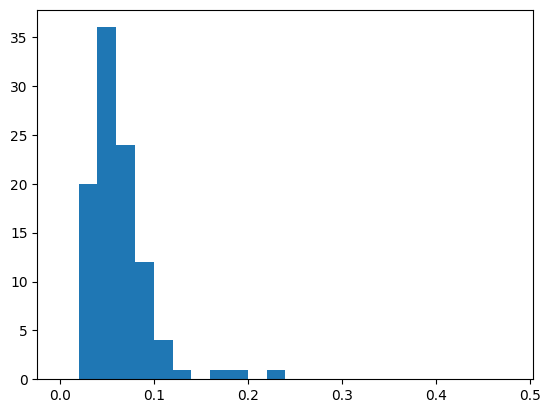

In [44]:
plt.hist(single_model_external_samples, bins=np.arange(0, 0.5, 0.02), label="external")

In [25]:
sp.stats.mannwhitneyu(internal_samples_logreg_90d, external_samples_logreg_90d, alternative='less')

MannwhitneyuResult(statistic=1685.0, pvalue=2.7768427739517915e-16)